# Importacion de Datos y librerias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

ds_hotels = pd.read_csv("./hotels_modificado_train.csv")
ds_h = ds_hotels.copy()
ds_h["agent"] = ds_h["agent"].apply(str)
ds = ds_h.drop(["id"], axis="columns", inplace=False)

# Clasificador KNN

In [2]:
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment", 
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent", 
"customer_type"]

ds = pd.get_dummies(ds, columns=var_cual, drop_first=True)
ds_x=ds.drop(['is_canceled'], axis='columns', inplace=False)
ds_y = ds['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y, 
                                                    test_size=0.25,  
                                                    random_state=4, 
                                                    stratify=ds["is_canceled"].values) 

KNN_Classifier = KNeighborsClassifier()
KNN_Classifier.fit(x_train, y_train)
y_pred = KNN_Classifier.predict(x_test)

In [3]:
def visualizar_predicciones(test,prediccion):
  tabla=confusion_matrix(y_test, y_pred)
  
  #Grafico la matriz de confusión
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  
  accuracy=accuracy_score(test,prediccion)
  recall=recall_score(test,prediccion)
  f1=f1_score(test,prediccion)
  precision=precision_score(test,prediccion)
  print("Accuracy: "+str(accuracy))
  print("Recall: "+str(recall))
  print("Precision: "+str(precision))
  print("f1 score: "+str(f1))


Accuracy: 0.6368008550053438
Recall: 0.48377445339470654
Precision: 0.5339090678181356
f1 score: 0.5076068582468003


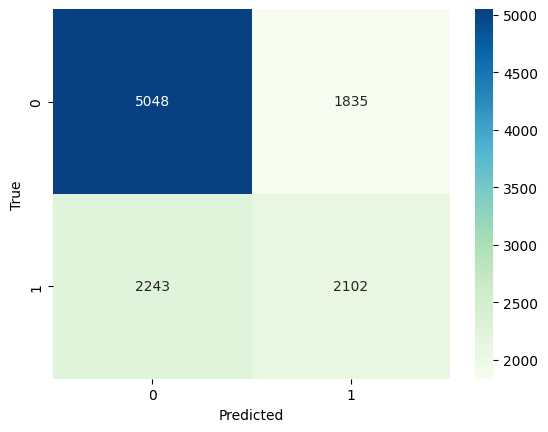

In [4]:
visualizar_predicciones(y_test, y_pred)

## Busqueda de parametros de KNN Clasificacion



In [5]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

#Predicción con mejor estimador
rand.fit(x_train, y_train)
mejor_knn = rand.best_estimator_
y_pred = mejor_knn.predict(x_test)

Accuracy: 0.6912183826148913
Recall: 0.5967779056386652
Precision: 0.6019034354688951
f1 score: 0.59932971223853


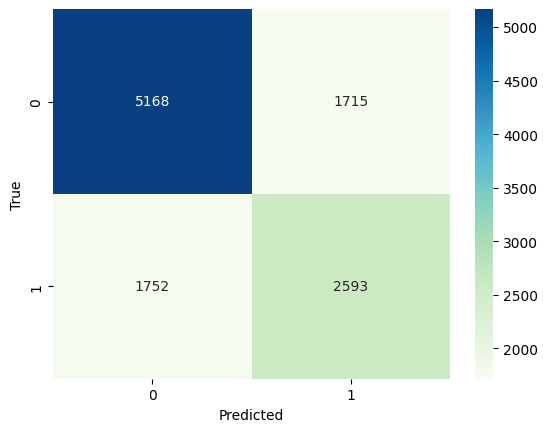

In [6]:
visualizar_predicciones(y_test, y_pred)

## Mejores hiperparametros para el la prediccion de KNN de clasificacion

In [7]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,50), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

rand = RandomizedSearchCV(knn, params_grid, cv=5, scoring='accuracy', n_iter=5, random_state=2)

#Predicción con mejor estimador
rand.fit(x_train, y_train)
mejor_knn = KNeighborsClassifier().set_params(**rand.best_params_)
mejor_knn.fit(x_train, y_train)
y_pred = mejor_knn.predict(x_test)

Accuracy: 0.6962949768436053
Recall: 0.5891829689298044
Precision: 0.6117084826762246
f1 score: 0.6002344665885111


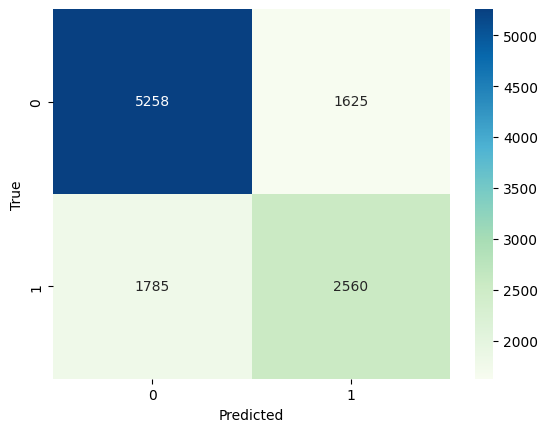

In [8]:
visualizar_predicciones(y_test,y_pred)

Tiene el mejor f1_score, el mejor accuracy y el mejor precision

## Predict de Kaglee con KNN clasicacion

In [10]:
ds_hotels_test = pd.read_csv("./hotels_test.csv")
ds_h_test = ds_hotels_test.copy()
ds_h_test.drop(columns="reservation_status_date", inplace=True)
ds_h_test.drop(columns= 'company', inplace = True)

#One hot encoding para variables categoricas
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment", 
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent", 
"customer_type"]
ds_h_test = pd.get_dummies(ds_h_test, columns=var_cual, drop_first=True)

# Agarramos las columnas diferentes de ds
diff_cols_df2 = set(ds.columns) - set(ds_h_test.columns)

# Agrego las columnas faltantes en ds_h_test y las inicializo en false
for col in diff_cols_df2:
    ds_h_test[col] = np.False_

# Solo me quedo con las columnas de ds_h_test que esten en ds
df_test = ds_h_test[ds.columns]

ds_kag = df_test.drop(["is_canceled"], axis="columns", inplace=True)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
pipeline = Pipeline([  ('imputer', imputer)])
pipeline.fit(ds)
#ds_copiado = ds_h_test.drop(columns="id", inplace=True)
#ds_h_test = pipeline.transform(ds_h_test)

# Obtener lista de columnas de ds
cols_ds = ds.columns

# Seleccionar solo las columnas presentes en ds en ds_h_test
cols_ds_h_test = [col for col in df_test.columns if col in cols_ds]

# Aplicar pipeline solo a las columnas presentes en ambos dataframes
pipeline.fit(ds[cols_ds_h_test])
df_test[cols_ds_h_test] = pipeline.transform(df_test[cols_ds_h_test])

y_pred_kaggle = mejor_knn.predict(df_test)

ds_kaggle = pd.DataFrame({'id': ds_h_test['id'], 'is_canceled': y_pred_kaggle})
print(ds_kaggle.shape)
ds_kaggle.to_csv('pred_kaggle.csv', index=False)

<ipython-input-10-ef526e61201c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_kag = df_test.drop(["is_canceled"], axis="columns", inplace=True)
<ipython-input-10-ef526e61201c>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[cols_ds_h_test] = pipeline.transform(df_test[cols_ds_h_test])


(26535, 2)


## Guardar el modelo de KNN

In [ ]:
mejor_knn.get_

In [12]:
import joblib
filename = 'model_knn.sav'
joblib.dump(rand, filename)

['model_knn.sav']